In [47]:
project_name = 'classification-dcgan'

In [48]:
DATA_DIR = r'C:\Project\Step1\GAN'

In [49]:
import os

print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/images')[:10])

['Images']
['img_1_F5_pid_125_P121_VER34_FR.png', 'img_1_F5_pid_125_P122_VER34_FR.png', 'img_1_F5_pid_125_P123_VER34_FR.png', 'img_1_F5_pid_125_P124_VER34_FR.png', 'img_1_F5_pid_125_P125_VER34_FR.png', 'img_1_F5_pid_125_P126_VER34_FR.png', 'img_1_F5_pid_125_P128_VER34_FR.png', 'img_1_F5_pid_154_P36_T9A.png', 'img_1_F5_pid_154_P37_T9A.png', 'img_1_F5_pid_156_P88_Amaze.png']


In [50]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [51]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [52]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [53]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [55]:
def show_images(images, nmax=48):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

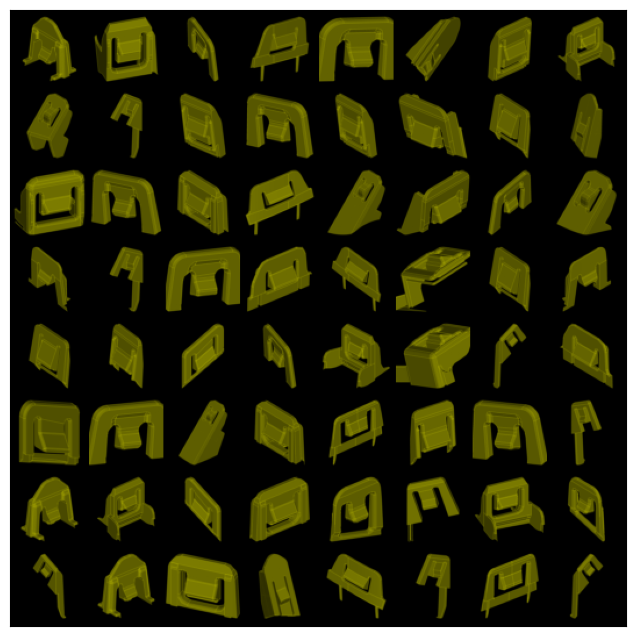

In [56]:
show_batch(train_dl)

In [57]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [58]:
device = get_default_device()
device

device(type='cpu')

In [59]:
train_dl = DeviceDataLoader(train_dl, device)

In [60]:
import torch.nn as nn

In [61]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

In [62]:
discriminator = to_device(discriminator, device)

In [63]:
latent_size = 128

In [64]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


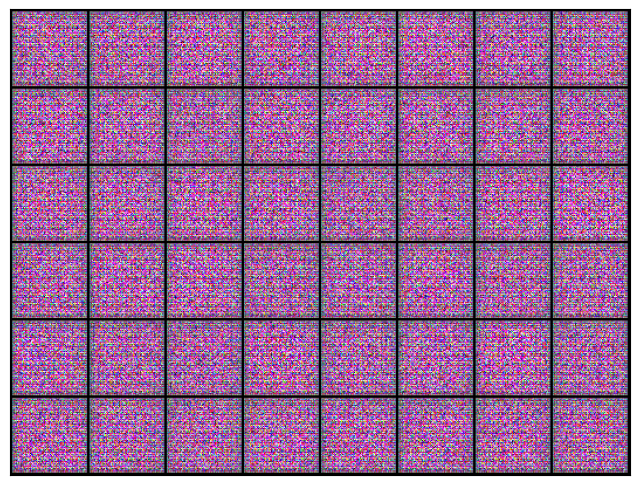

In [65]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [66]:
generator = to_device(generator, device)

In [67]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [68]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [69]:
from torchvision.utils import save_image

In [70]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [71]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [72]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


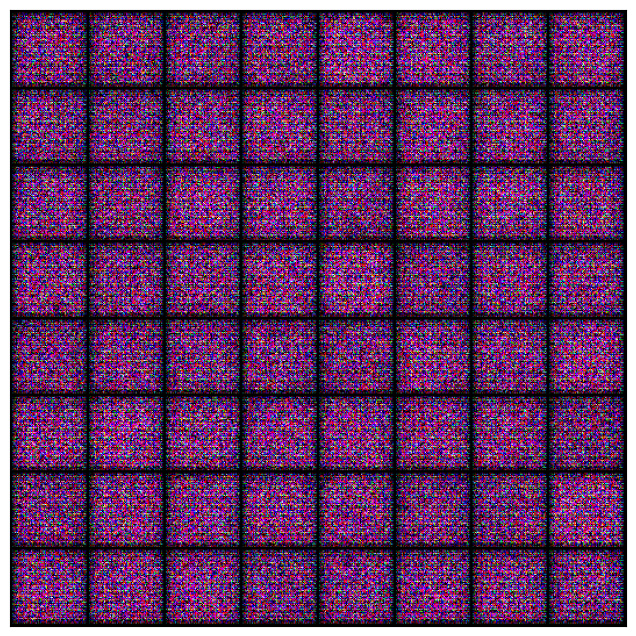

In [73]:
save_samples(0, fixed_latent)

In [74]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [75]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
         # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [76]:
lr = 0.0002
epochs = 250

In [77]:
history = fit(epochs, lr)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/250], loss_g: 3.1639, loss_d: 1.2044, real_score: 0.9864, fake_score: 0.6842
Saving generated-images-0001.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/250], loss_g: 4.3952, loss_d: 0.2797, real_score: 0.8795, fake_score: 0.1366
Saving generated-images-0002.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/250], loss_g: 4.7288, loss_d: 0.2743, real_score: 0.8507, fake_score: 0.0975
Saving generated-images-0003.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/250], loss_g: 6.2843, loss_d: 0.0625, real_score: 0.9969, fake_score: 0.0573
Saving generated-images-0004.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/250], loss_g: 6.5776, loss_d: 0.0835, real_score: 0.9968, fake_score: 0.0766
Saving generated-images-0005.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/250], loss_g: 6.4215, loss_d: 0.1047, real_score: 0.9542, fake_score: 0.0541
Saving generated-images-0006.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/250], loss_g: 6.8477, loss_d: 0.0308, real_score: 0.9945, fake_score: 0.0249
Saving generated-images-0007.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/250], loss_g: 7.0000, loss_d: 0.0276, real_score: 0.9935, fake_score: 0.0208
Saving generated-images-0008.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/250], loss_g: 7.1117, loss_d: 0.0260, real_score: 0.9966, fake_score: 0.0223
Saving generated-images-0009.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/250], loss_g: 7.0908, loss_d: 0.0209, real_score: 0.9967, fake_score: 0.0174
Saving generated-images-0010.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/250], loss_g: 7.3372, loss_d: 0.0181, real_score: 0.9970, fake_score: 0.0149
Saving generated-images-0011.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/250], loss_g: 7.4160, loss_d: 0.0262, real_score: 0.9911, fake_score: 0.0170
Saving generated-images-0012.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/250], loss_g: 7.5648, loss_d: 0.0163, real_score: 0.9981, fake_score: 0.0142
Saving generated-images-0013.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/250], loss_g: 7.5680, loss_d: 0.0146, real_score: 0.9988, fake_score: 0.0133
Saving generated-images-0014.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/250], loss_g: 7.3053, loss_d: 0.0141, real_score: 0.9960, fake_score: 0.0101
Saving generated-images-0015.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/250], loss_g: 7.3806, loss_d: 0.0096, real_score: 0.9989, fake_score: 0.0084
Saving generated-images-0016.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/250], loss_g: 7.1419, loss_d: 0.0098, real_score: 0.9976, fake_score: 0.0074
Saving generated-images-0017.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/250], loss_g: 7.0337, loss_d: 0.0146, real_score: 0.9929, fake_score: 0.0073
Saving generated-images-0018.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/250], loss_g: 7.3191, loss_d: 0.0079, real_score: 0.9987, fake_score: 0.0066
Saving generated-images-0019.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/250], loss_g: 7.2835, loss_d: 0.0074, real_score: 0.9990, fake_score: 0.0064
Saving generated-images-0020.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/250], loss_g: 7.3470, loss_d: 0.0093, real_score: 0.9969, fake_score: 0.0061
Saving generated-images-0021.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/250], loss_g: 7.6366, loss_d: 0.0067, real_score: 0.9992, fake_score: 0.0059
Saving generated-images-0022.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/250], loss_g: 7.3889, loss_d: 0.0061, real_score: 0.9993, fake_score: 0.0054
Saving generated-images-0023.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/250], loss_g: 7.5533, loss_d: 0.0074, real_score: 0.9985, fake_score: 0.0059
Saving generated-images-0024.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/250], loss_g: 7.5671, loss_d: 0.0120, real_score: 0.9940, fake_score: 0.0060
Saving generated-images-0025.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26/250], loss_g: 7.6431, loss_d: 0.0054, real_score: 0.9995, fake_score: 0.0049
Saving generated-images-0026.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27/250], loss_g: 7.6355, loss_d: 0.0055, real_score: 0.9994, fake_score: 0.0049
Saving generated-images-0027.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28/250], loss_g: 7.5521, loss_d: 0.0050, real_score: 0.9997, fake_score: 0.0047
Saving generated-images-0028.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29/250], loss_g: 7.4638, loss_d: 0.0074, real_score: 0.9966, fake_score: 0.0040
Saving generated-images-0029.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30/250], loss_g: 7.5274, loss_d: 0.0087, real_score: 0.9961, fake_score: 0.0047
Saving generated-images-0030.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31/250], loss_g: 7.8847, loss_d: 0.0040, real_score: 0.9999, fake_score: 0.0039
Saving generated-images-0031.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32/250], loss_g: 7.6753, loss_d: 0.0044, real_score: 0.9997, fake_score: 0.0041
Saving generated-images-0032.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33/250], loss_g: 7.7562, loss_d: 0.0038, real_score: 0.9993, fake_score: 0.0032
Saving generated-images-0033.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34/250], loss_g: 7.6594, loss_d: 0.0056, real_score: 0.9986, fake_score: 0.0042
Saving generated-images-0034.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35/250], loss_g: 7.6575, loss_d: 0.0039, real_score: 0.9988, fake_score: 0.0027
Saving generated-images-0035.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36/250], loss_g: 7.4513, loss_d: 0.0052, real_score: 0.9993, fake_score: 0.0045
Saving generated-images-0036.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [37/250], loss_g: 7.7387, loss_d: 0.0040, real_score: 0.9992, fake_score: 0.0032
Saving generated-images-0037.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38/250], loss_g: 7.4223, loss_d: 0.0031, real_score: 0.9998, fake_score: 0.0029
Saving generated-images-0038.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39/250], loss_g: 7.4732, loss_d: 0.0052, real_score: 0.9981, fake_score: 0.0032
Saving generated-images-0039.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40/250], loss_g: 7.7078, loss_d: 0.0053, real_score: 0.9982, fake_score: 0.0036
Saving generated-images-0040.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41/250], loss_g: 7.6246, loss_d: 0.0053, real_score: 0.9977, fake_score: 0.0030
Saving generated-images-0041.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42/250], loss_g: 7.8177, loss_d: 0.0050, real_score: 0.9987, fake_score: 0.0037
Saving generated-images-0042.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43/250], loss_g: 7.8206, loss_d: 0.0051, real_score: 0.9984, fake_score: 0.0035
Saving generated-images-0043.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44/250], loss_g: 7.4292, loss_d: 0.0088, real_score: 0.9942, fake_score: 0.0029
Saving generated-images-0044.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45/250], loss_g: 7.8691, loss_d: 0.0028, real_score: 0.9999, fake_score: 0.0028
Saving generated-images-0045.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46/250], loss_g: 7.9182, loss_d: 0.0035, real_score: 0.9995, fake_score: 0.0030
Saving generated-images-0046.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47/250], loss_g: 8.0748, loss_d: 0.0032, real_score: 0.9994, fake_score: 0.0026
Saving generated-images-0047.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48/250], loss_g: 7.7286, loss_d: 0.0031, real_score: 0.9991, fake_score: 0.0022
Saving generated-images-0048.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49/250], loss_g: 8.0123, loss_d: 0.0040, real_score: 0.9992, fake_score: 0.0032
Saving generated-images-0049.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50/250], loss_g: 7.6096, loss_d: 0.0056, real_score: 0.9972, fake_score: 0.0028
Saving generated-images-0050.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [51/250], loss_g: 7.9995, loss_d: 0.0059, real_score: 0.9973, fake_score: 0.0033
Saving generated-images-0051.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [52/250], loss_g: 8.4790, loss_d: 0.0039, real_score: 0.9996, fake_score: 0.0035
Saving generated-images-0052.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [53/250], loss_g: 4.7016, loss_d: 0.0210, real_score: 0.9810, fake_score: 0.0016
Saving generated-images-0053.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [54/250], loss_g: 17.0742, loss_d: 3.7649, real_score: 0.0905, fake_score: 0.0000
Saving generated-images-0054.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [55/250], loss_g: 21.6639, loss_d: 8.2828, real_score: 1.0000, fake_score: 0.9997
Saving generated-images-0055.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [56/250], loss_g: 17.0867, loss_d: 0.0347, real_score: 0.9676, fake_score: 0.0000
Saving generated-images-0056.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [57/250], loss_g: 12.1652, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0057.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [58/250], loss_g: 5.0614, loss_d: 0.0995, real_score: 0.9998, fake_score: 0.0943
Saving generated-images-0058.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [59/250], loss_g: 13.7934, loss_d: 0.3009, real_score: 0.7512, fake_score: 0.0000
Saving generated-images-0059.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [60/250], loss_g: 12.3745, loss_d: 0.0090, real_score: 0.9910, fake_score: 0.0000
Saving generated-images-0060.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [61/250], loss_g: 9.4109, loss_d: 0.0020, real_score: 0.9981, fake_score: 0.0001
Saving generated-images-0061.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [62/250], loss_g: 13.1858, loss_d: 1.9103, real_score: 0.9980, fake_score: 0.8490
Saving generated-images-0062.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [63/250], loss_g: 13.9640, loss_d: 0.1713, real_score: 0.8507, fake_score: 0.0000
Saving generated-images-0063.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [64/250], loss_g: 13.0603, loss_d: 0.0103, real_score: 0.9898, fake_score: 0.0000
Saving generated-images-0064.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [65/250], loss_g: 11.7085, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0065.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [66/250], loss_g: 9.0429, loss_d: 0.0015, real_score: 0.9986, fake_score: 0.0001
Saving generated-images-0066.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [67/250], loss_g: 12.8531, loss_d: 4.5403, real_score: 0.9977, fake_score: 0.9887
Saving generated-images-0067.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [68/250], loss_g: 13.5178, loss_d: 0.3898, real_score: 0.7207, fake_score: 0.0000
Saving generated-images-0068.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [69/250], loss_g: 12.3646, loss_d: 0.0229, real_score: 0.9778, fake_score: 0.0000
Saving generated-images-0069.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [70/250], loss_g: 10.5800, loss_d: 0.0034, real_score: 0.9966, fake_score: 0.0000
Saving generated-images-0070.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [71/250], loss_g: 6.1802, loss_d: 0.0027, real_score: 0.9995, fake_score: 0.0022
Saving generated-images-0071.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [72/250], loss_g: 11.6917, loss_d: 0.0962, real_score: 0.9250, fake_score: 0.0001
Saving generated-images-0072.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [73/250], loss_g: 9.8602, loss_d: 0.0328, real_score: 0.9684, fake_score: 0.0001
Saving generated-images-0073.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [74/250], loss_g: 4.6267, loss_d: 0.0579, real_score: 0.9833, fake_score: 0.0397
Saving generated-images-0074.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [75/250], loss_g: 13.0335, loss_d: 2.1961, real_score: 0.1199, fake_score: 0.0000
Saving generated-images-0075.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [76/250], loss_g: 8.4195, loss_d: 0.0041, real_score: 0.9960, fake_score: 0.0001
Saving generated-images-0076.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [77/250], loss_g: 12.6404, loss_d: 4.2851, real_score: 0.9985, fake_score: 0.9858
Saving generated-images-0077.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [78/250], loss_g: 12.3751, loss_d: 1.2976, real_score: 0.3757, fake_score: 0.0000
Saving generated-images-0078.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [79/250], loss_g: 4.4960, loss_d: 0.0130, real_score: 0.9942, fake_score: 0.0071
Saving generated-images-0079.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [80/250], loss_g: 11.8470, loss_d: 0.7410, real_score: 0.4815, fake_score: 0.0000
Saving generated-images-0080.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [81/250], loss_g: 5.2188, loss_d: 0.0582, real_score: 0.9477, fake_score: 0.0028
Saving generated-images-0081.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [82/250], loss_g: 7.7285, loss_d: 0.2265, real_score: 0.9879, fake_score: 0.1921
Saving generated-images-0082.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [83/250], loss_g: 11.9706, loss_d: 0.6874, real_score: 0.8854, fake_score: 0.4273
Saving generated-images-0083.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [84/250], loss_g: 11.0505, loss_d: 3.5825, real_score: 0.9973, fake_score: 0.9715
Saving generated-images-0084.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [85/250], loss_g: 8.4307, loss_d: 0.4632, real_score: 0.6368, fake_score: 0.0002
Saving generated-images-0085.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [86/250], loss_g: 4.2100, loss_d: 0.2782, real_score: 0.9844, fake_score: 0.2228
Saving generated-images-0086.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [87/250], loss_g: 3.3039, loss_d: 0.6391, real_score: 0.5649, fake_score: 0.0246
Saving generated-images-0087.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [88/250], loss_g: 2.7685, loss_d: 1.1260, real_score: 0.3816, fake_score: 0.0071
Saving generated-images-0088.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [89/250], loss_g: 4.5650, loss_d: 0.4631, real_score: 0.6701, fake_score: 0.0155
Saving generated-images-0089.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [90/250], loss_g: 8.6307, loss_d: 0.9197, real_score: 0.9688, fake_score: 0.5536
Saving generated-images-0090.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [91/250], loss_g: 3.7464, loss_d: 1.6794, real_score: 0.9726, fake_score: 0.7816
Saving generated-images-0091.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [92/250], loss_g: 1.7575, loss_d: 0.8881, real_score: 0.5345, fake_score: 0.1695
Saving generated-images-0092.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [93/250], loss_g: 2.8900, loss_d: 0.5360, real_score: 0.7495, fake_score: 0.1923
Saving generated-images-0093.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [94/250], loss_g: 4.1433, loss_d: 0.9078, real_score: 0.9509, fake_score: 0.5581
Saving generated-images-0094.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [95/250], loss_g: 3.8616, loss_d: 1.0462, real_score: 0.9619, fake_score: 0.6201
Saving generated-images-0095.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [96/250], loss_g: 1.3504, loss_d: 0.4740, real_score: 0.7431, fake_score: 0.1213
Saving generated-images-0096.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [97/250], loss_g: 1.0228, loss_d: 1.0176, real_score: 0.4136, fake_score: 0.0277
Saving generated-images-0097.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [98/250], loss_g: 3.4628, loss_d: 0.4177, real_score: 0.7043, fake_score: 0.0604
Saving generated-images-0098.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [99/250], loss_g: 2.4679, loss_d: 0.2893, real_score: 0.8939, fake_score: 0.1526
Saving generated-images-0099.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [100/250], loss_g: 1.4145, loss_d: 0.5079, real_score: 0.6709, fake_score: 0.0744
Saving generated-images-0100.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [101/250], loss_g: 1.9919, loss_d: 0.6607, real_score: 0.5465, fake_score: 0.0279
Saving generated-images-0101.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [102/250], loss_g: 4.2696, loss_d: 0.2173, real_score: 0.8999, fake_score: 0.0924
Saving generated-images-0102.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [103/250], loss_g: 3.2615, loss_d: 0.3139, real_score: 0.9129, fake_score: 0.1903
Saving generated-images-0103.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [104/250], loss_g: 3.4139, loss_d: 0.1476, real_score: 0.9302, fake_score: 0.0714
Saving generated-images-0104.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [105/250], loss_g: 4.3755, loss_d: 0.1852, real_score: 0.8492, fake_score: 0.0190
Saving generated-images-0105.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [106/250], loss_g: 2.9162, loss_d: 0.1553, real_score: 0.9013, fake_score: 0.0485
Saving generated-images-0106.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [107/250], loss_g: 0.1443, loss_d: 1.8269, real_score: 0.1962, fake_score: 0.0004
Saving generated-images-0107.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [108/250], loss_g: 8.7379, loss_d: 0.1362, real_score: 0.8914, fake_score: 0.0062
Saving generated-images-0108.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [109/250], loss_g: 3.1227, loss_d: 0.7732, real_score: 0.9013, fake_score: 0.3932
Saving generated-images-0109.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [110/250], loss_g: 0.7727, loss_d: 1.7745, real_score: 0.2142, fake_score: 0.0480
Saving generated-images-0110.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [111/250], loss_g: 2.4443, loss_d: 1.3147, real_score: 0.3436, fake_score: 0.1110
Saving generated-images-0111.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [112/250], loss_g: 1.3329, loss_d: 1.0258, real_score: 0.4972, fake_score: 0.2159
Saving generated-images-0112.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [113/250], loss_g: 4.6299, loss_d: 0.4000, real_score: 0.7405, fake_score: 0.0254
Saving generated-images-0113.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [114/250], loss_g: 3.0727, loss_d: 0.3058, real_score: 0.9569, fake_score: 0.2141
Saving generated-images-0114.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [115/250], loss_g: 3.2053, loss_d: 0.3302, real_score: 0.8161, fake_score: 0.1128
Saving generated-images-0115.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [116/250], loss_g: 3.1532, loss_d: 0.4941, real_score: 0.8354, fake_score: 0.2525
Saving generated-images-0116.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [117/250], loss_g: 2.3205, loss_d: 0.3448, real_score: 0.7945, fake_score: 0.0932
Saving generated-images-0117.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [118/250], loss_g: 0.1521, loss_d: 1.8602, real_score: 0.2201, fake_score: 0.0061
Saving generated-images-0118.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [119/250], loss_g: 0.4160, loss_d: 2.7836, real_score: 0.0816, fake_score: 0.0057
Saving generated-images-0119.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [120/250], loss_g: 3.7401, loss_d: 0.6142, real_score: 0.8183, fake_score: 0.3192
Saving generated-images-0120.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [121/250], loss_g: 2.0502, loss_d: 0.5022, real_score: 0.8900, fake_score: 0.3054
Saving generated-images-0121.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [122/250], loss_g: 1.6533, loss_d: 0.6872, real_score: 0.6389, fake_score: 0.1811
Saving generated-images-0122.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [123/250], loss_g: 0.8859, loss_d: 1.1139, real_score: 0.4083, fake_score: 0.1398
Saving generated-images-0123.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [124/250], loss_g: 2.1204, loss_d: 1.0082, real_score: 0.4557, fake_score: 0.0755
Saving generated-images-0124.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [125/250], loss_g: 2.7084, loss_d: 0.5544, real_score: 0.8185, fake_score: 0.2278
Saving generated-images-0125.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [126/250], loss_g: 2.9772, loss_d: 0.2673, real_score: 0.8858, fake_score: 0.1289
Saving generated-images-0126.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [127/250], loss_g: 2.6124, loss_d: 0.2865, real_score: 0.8629, fake_score: 0.1035
Saving generated-images-0127.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [128/250], loss_g: 4.4682, loss_d: 0.1586, real_score: 0.9211, fake_score: 0.0710
Saving generated-images-0128.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [129/250], loss_g: 6.1811, loss_d: 0.7699, real_score: 0.9780, fake_score: 0.4984
Saving generated-images-0129.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [130/250], loss_g: 4.9079, loss_d: 1.3826, real_score: 0.9894, fake_score: 0.7063
Saving generated-images-0130.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [131/250], loss_g: 2.5667, loss_d: 0.2939, real_score: 0.8297, fake_score: 0.0827
Saving generated-images-0131.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [132/250], loss_g: 2.9859, loss_d: 0.4034, real_score: 0.8309, fake_score: 0.1818
Saving generated-images-0132.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [133/250], loss_g: 2.7118, loss_d: 0.6868, real_score: 0.7786, fake_score: 0.3348
Saving generated-images-0133.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [134/250], loss_g: 2.6994, loss_d: 0.5714, real_score: 0.7680, fake_score: 0.2481
Saving generated-images-0134.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [135/250], loss_g: 0.3259, loss_d: 1.0218, real_score: 0.5027, fake_score: 0.1185
Saving generated-images-0135.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [136/250], loss_g: 3.3852, loss_d: 2.0491, real_score: 0.1876, fake_score: 0.0009
Saving generated-images-0136.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [137/250], loss_g: 2.8472, loss_d: 0.7441, real_score: 0.9213, fake_score: 0.4457
Saving generated-images-0137.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [138/250], loss_g: 1.4443, loss_d: 0.6167, real_score: 0.6566, fake_score: 0.1495
Saving generated-images-0138.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [139/250], loss_g: 2.7526, loss_d: 0.5266, real_score: 0.6549, fake_score: 0.0672
Saving generated-images-0139.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [140/250], loss_g: 3.9692, loss_d: 0.7032, real_score: 0.8265, fake_score: 0.3686
Saving generated-images-0140.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [141/250], loss_g: 2.6817, loss_d: 0.4755, real_score: 0.8386, fake_score: 0.2377
Saving generated-images-0141.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [142/250], loss_g: 2.2487, loss_d: 0.5488, real_score: 0.6852, fake_score: 0.0565
Saving generated-images-0142.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [143/250], loss_g: 1.5293, loss_d: 0.5809, real_score: 0.5904, fake_score: 0.0271
Saving generated-images-0143.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [144/250], loss_g: 3.2160, loss_d: 0.5633, real_score: 0.6410, fake_score: 0.0167
Saving generated-images-0144.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [145/250], loss_g: 0.5257, loss_d: 0.8355, real_score: 0.5948, fake_score: 0.1861
Saving generated-images-0145.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [146/250], loss_g: 3.4242, loss_d: 2.5385, real_score: 0.1254, fake_score: 0.0007
Saving generated-images-0146.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [147/250], loss_g: 2.0067, loss_d: 1.1579, real_score: 0.7133, fake_score: 0.4646
Saving generated-images-0147.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [148/250], loss_g: 1.6006, loss_d: 1.1765, real_score: 0.4791, fake_score: 0.0700
Saving generated-images-0148.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [149/250], loss_g: 3.7183, loss_d: 0.3391, real_score: 0.9492, fake_score: 0.2294
Saving generated-images-0149.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [150/250], loss_g: 2.0454, loss_d: 0.4788, real_score: 0.8730, fake_score: 0.2772
Saving generated-images-0150.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [151/250], loss_g: 2.5141, loss_d: 0.3688, real_score: 0.7949, fake_score: 0.1248
Saving generated-images-0151.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [152/250], loss_g: 2.6059, loss_d: 0.3111, real_score: 0.8596, fake_score: 0.1419
Saving generated-images-0152.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [153/250], loss_g: 2.3529, loss_d: 0.3894, real_score: 0.8192, fake_score: 0.1625
Saving generated-images-0153.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [154/250], loss_g: 3.4260, loss_d: 0.2702, real_score: 0.8893, fake_score: 0.1355
Saving generated-images-0154.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [155/250], loss_g: 6.9788, loss_d: 1.2183, real_score: 0.9851, fake_score: 0.6679
Saving generated-images-0155.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [156/250], loss_g: 1.3974, loss_d: 0.3924, real_score: 0.9313, fake_score: 0.2597
Saving generated-images-0156.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [157/250], loss_g: 2.3397, loss_d: 0.6649, real_score: 0.6124, fake_score: 0.0626
Saving generated-images-0157.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [158/250], loss_g: 2.4194, loss_d: 0.4465, real_score: 0.7966, fake_score: 0.1793
Saving generated-images-0158.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [159/250], loss_g: 2.2092, loss_d: 0.4296, real_score: 0.7813, fake_score: 0.1356
Saving generated-images-0159.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [160/250], loss_g: 2.6799, loss_d: 0.4478, real_score: 0.8113, fake_score: 0.1417
Saving generated-images-0160.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [161/250], loss_g: 2.8878, loss_d: 0.3264, real_score: 0.8950, fake_score: 0.1792
Saving generated-images-0161.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [162/250], loss_g: 1.8321, loss_d: 0.4539, real_score: 0.7616, fake_score: 0.1441
Saving generated-images-0162.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [163/250], loss_g: 1.2089, loss_d: 0.6921, real_score: 0.5800, fake_score: 0.0769
Saving generated-images-0163.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [164/250], loss_g: 2.9836, loss_d: 0.7953, real_score: 0.5294, fake_score: 0.0238
Saving generated-images-0164.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [165/250], loss_g: 3.4816, loss_d: 0.4051, real_score: 0.9581, fake_score: 0.2825
Saving generated-images-0165.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [166/250], loss_g: 3.2916, loss_d: 0.3659, real_score: 0.9543, fake_score: 0.2619
Saving generated-images-0166.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [167/250], loss_g: 1.5873, loss_d: 0.6881, real_score: 0.6744, fake_score: 0.2064
Saving generated-images-0167.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [168/250], loss_g: 3.4569, loss_d: 0.9394, real_score: 0.5190, fake_score: 0.0135
Saving generated-images-0168.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [169/250], loss_g: 4.5967, loss_d: 0.6556, real_score: 0.8940, fake_score: 0.3666
Saving generated-images-0169.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [170/250], loss_g: 2.9715, loss_d: 0.3852, real_score: 0.9000, fake_score: 0.2304
Saving generated-images-0170.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [171/250], loss_g: 0.4855, loss_d: 1.2817, real_score: 0.3897, fake_score: 0.0732
Saving generated-images-0171.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [172/250], loss_g: 4.1428, loss_d: 1.0325, real_score: 0.4927, fake_score: 0.0076
Saving generated-images-0172.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [173/250], loss_g: 3.0388, loss_d: 0.4715, real_score: 0.9342, fake_score: 0.3005
Saving generated-images-0173.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [174/250], loss_g: 2.4564, loss_d: 0.3872, real_score: 0.7701, fake_score: 0.1001
Saving generated-images-0174.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [175/250], loss_g: 3.7948, loss_d: 0.3987, real_score: 0.9371, fake_score: 0.2617
Saving generated-images-0175.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [176/250], loss_g: 2.9715, loss_d: 0.5391, real_score: 0.8788, fake_score: 0.3148
Saving generated-images-0176.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [177/250], loss_g: 3.1422, loss_d: 0.1733, real_score: 0.9076, fake_score: 0.0685
Saving generated-images-0177.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [178/250], loss_g: 3.8445, loss_d: 0.1849, real_score: 0.9725, fake_score: 0.1387
Saving generated-images-0178.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [179/250], loss_g: 3.3549, loss_d: 0.4381, real_score: 0.9005, fake_score: 0.2637
Saving generated-images-0179.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [180/250], loss_g: 3.6157, loss_d: 0.2031, real_score: 0.9541, fake_score: 0.1389
Saving generated-images-0180.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [181/250], loss_g: 3.2291, loss_d: 0.3184, real_score: 0.8983, fake_score: 0.1807
Saving generated-images-0181.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [182/250], loss_g: 1.5189, loss_d: 0.4462, real_score: 0.7481, fake_score: 0.1361
Saving generated-images-0182.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [183/250], loss_g: 0.6709, loss_d: 2.8497, real_score: 0.1875, fake_score: 0.0016
Saving generated-images-0183.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [184/250], loss_g: 4.9544, loss_d: 0.2888, real_score: 0.7852, fake_score: 0.0203
Saving generated-images-0184.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [185/250], loss_g: 2.7628, loss_d: 0.8353, real_score: 0.9967, fake_score: 0.5135
Saving generated-images-0185.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [186/250], loss_g: 0.7100, loss_d: 1.0214, real_score: 0.4409, fake_score: 0.0692
Saving generated-images-0186.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [187/250], loss_g: 3.5661, loss_d: 0.5622, real_score: 0.7605, fake_score: 0.1852
Saving generated-images-0187.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [188/250], loss_g: 2.2884, loss_d: 0.5227, real_score: 0.8498, fake_score: 0.2579
Saving generated-images-0188.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [189/250], loss_g: 3.0229, loss_d: 0.3109, real_score: 0.8397, fake_score: 0.1186
Saving generated-images-0189.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [190/250], loss_g: 3.1771, loss_d: 0.7444, real_score: 0.8032, fake_score: 0.3737
Saving generated-images-0190.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [191/250], loss_g: 1.7744, loss_d: 0.5190, real_score: 0.7155, fake_score: 0.1428
Saving generated-images-0191.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [192/250], loss_g: 1.9261, loss_d: 0.9404, real_score: 0.5504, fake_score: 0.0183
Saving generated-images-0192.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [193/250], loss_g: 3.6984, loss_d: 0.2716, real_score: 0.8950, fake_score: 0.1265
Saving generated-images-0193.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [194/250], loss_g: 2.6497, loss_d: 0.3794, real_score: 0.8797, fake_score: 0.2040
Saving generated-images-0194.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [195/250], loss_g: 2.7013, loss_d: 0.4153, real_score: 0.7269, fake_score: 0.0521
Saving generated-images-0195.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [196/250], loss_g: 0.4214, loss_d: 0.7210, real_score: 0.5464, fake_score: 0.0824
Saving generated-images-0196.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [197/250], loss_g: 8.0420, loss_d: 0.1202, real_score: 0.9053, fake_score: 0.0028
Saving generated-images-0197.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [198/250], loss_g: 1.9759, loss_d: 1.4217, real_score: 0.9970, fake_score: 0.6637
Saving generated-images-0198.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [199/250], loss_g: 2.9309, loss_d: 0.5939, real_score: 0.6424, fake_score: 0.0742
Saving generated-images-0199.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [200/250], loss_g: 2.5576, loss_d: 0.5515, real_score: 0.8601, fake_score: 0.3048
Saving generated-images-0200.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [201/250], loss_g: 1.3730, loss_d: 0.8339, real_score: 0.5667, fake_score: 0.1292
Saving generated-images-0201.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [202/250], loss_g: 4.0821, loss_d: 0.2573, real_score: 0.8182, fake_score: 0.0414
Saving generated-images-0202.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [203/250], loss_g: 3.0485, loss_d: 0.9345, real_score: 0.9024, fake_score: 0.5118
Saving generated-images-0203.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [204/250], loss_g: 1.4520, loss_d: 0.5336, real_score: 0.6280, fake_score: 0.0446
Saving generated-images-0204.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [205/250], loss_g: 3.2408, loss_d: 0.3043, real_score: 0.8041, fake_score: 0.0674
Saving generated-images-0205.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [206/250], loss_g: 3.2594, loss_d: 0.3441, real_score: 0.9891, fake_score: 0.2658
Saving generated-images-0206.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [207/250], loss_g: 3.2066, loss_d: 0.3080, real_score: 0.9676, fake_score: 0.2260
Saving generated-images-0207.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [208/250], loss_g: 0.6364, loss_d: 0.8364, real_score: 0.5801, fake_score: 0.2164
Saving generated-images-0208.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [209/250], loss_g: 2.3150, loss_d: 1.6423, real_score: 0.3209, fake_score: 0.0047
Saving generated-images-0209.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [210/250], loss_g: 3.7506, loss_d: 0.4749, real_score: 0.9520, fake_score: 0.2928
Saving generated-images-0210.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [211/250], loss_g: 1.4103, loss_d: 0.5077, real_score: 0.7529, fake_score: 0.1680
Saving generated-images-0211.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [212/250], loss_g: 2.3305, loss_d: 0.4761, real_score: 0.6958, fake_score: 0.0671
Saving generated-images-0212.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [213/250], loss_g: 2.6156, loss_d: 0.4340, real_score: 0.8260, fake_score: 0.1965
Saving generated-images-0213.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [214/250], loss_g: 3.4772, loss_d: 0.2251, real_score: 0.9325, fake_score: 0.1374
Saving generated-images-0214.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [215/250], loss_g: 5.4315, loss_d: 0.5905, real_score: 0.9485, fake_score: 0.3890
Saving generated-images-0215.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [216/250], loss_g: 2.8843, loss_d: 1.7899, real_score: 0.5515, fake_score: 0.6363
Saving generated-images-0216.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [217/250], loss_g: 4.0302, loss_d: 0.1590, real_score: 0.8846, fake_score: 0.0298
Saving generated-images-0217.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [218/250], loss_g: 5.8948, loss_d: 1.6334, real_score: 0.9266, fake_score: 0.7445
Saving generated-images-0218.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [219/250], loss_g: 2.1124, loss_d: 0.6800, real_score: 0.9218, fake_score: 0.4048
Saving generated-images-0219.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [220/250], loss_g: 0.4223, loss_d: 1.9735, real_score: 0.2072, fake_score: 0.0534
Saving generated-images-0220.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [221/250], loss_g: 3.8616, loss_d: 0.3602, real_score: 0.7904, fake_score: 0.1005
Saving generated-images-0221.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [222/250], loss_g: 1.9573, loss_d: 0.5979, real_score: 0.8712, fake_score: 0.3407
Saving generated-images-0222.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [223/250], loss_g: 2.8633, loss_d: 0.2591, real_score: 0.8390, fake_score: 0.0724
Saving generated-images-0223.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [224/250], loss_g: 2.5221, loss_d: 0.3914, real_score: 0.8771, fake_score: 0.2176
Saving generated-images-0224.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [225/250], loss_g: 2.0223, loss_d: 0.3675, real_score: 0.7780, fake_score: 0.0876
Saving generated-images-0225.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [226/250], loss_g: 0.3927, loss_d: 0.8836, real_score: 0.4773, fake_score: 0.0620
Saving generated-images-0226.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [227/250], loss_g: 2.1251, loss_d: 1.7085, real_score: 0.2740, fake_score: 0.0091
Saving generated-images-0227.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [228/250], loss_g: 2.9015, loss_d: 0.5438, real_score: 0.8168, fake_score: 0.2498
Saving generated-images-0228.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [229/250], loss_g: 2.5752, loss_d: 0.4576, real_score: 0.8222, fake_score: 0.2065
Saving generated-images-0229.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [230/250], loss_g: 2.7781, loss_d: 0.2804, real_score: 0.8730, fake_score: 0.1258
Saving generated-images-0230.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [231/250], loss_g: 1.5903, loss_d: 0.4624, real_score: 0.7467, fake_score: 0.1413
Saving generated-images-0231.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [232/250], loss_g: 1.9340, loss_d: 0.8188, real_score: 0.4643, fake_score: 0.0228
Saving generated-images-0232.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [233/250], loss_g: 0.1384, loss_d: 2.3592, real_score: 0.1270, fake_score: 0.1030
Saving generated-images-0233.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [234/250], loss_g: 2.2749, loss_d: 1.4997, real_score: 0.3822, fake_score: 0.2335
Saving generated-images-0234.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [235/250], loss_g: 2.1040, loss_d: 0.7541, real_score: 0.7728, fake_score: 0.3500
Saving generated-images-0235.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [236/250], loss_g: 2.2469, loss_d: 0.6177, real_score: 0.6719, fake_score: 0.1639
Saving generated-images-0236.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [237/250], loss_g: 2.5762, loss_d: 0.4401, real_score: 0.8309, fake_score: 0.2104
Saving generated-images-0237.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [238/250], loss_g: 1.8200, loss_d: 0.6158, real_score: 0.7776, fake_score: 0.2435
Saving generated-images-0238.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [239/250], loss_g: 2.2684, loss_d: 0.4409, real_score: 0.7882, fake_score: 0.1529
Saving generated-images-0239.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [240/250], loss_g: 1.1926, loss_d: 0.5686, real_score: 0.6846, fake_score: 0.1098
Saving generated-images-0240.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [241/250], loss_g: 3.1147, loss_d: 0.6431, real_score: 0.5992, fake_score: 0.0232
Saving generated-images-0241.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [242/250], loss_g: 4.1437, loss_d: 0.4076, real_score: 0.9863, fake_score: 0.2954
Saving generated-images-0242.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [243/250], loss_g: 3.3600, loss_d: 0.2197, real_score: 0.9764, fake_score: 0.1690
Saving generated-images-0243.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [244/250], loss_g: 2.9888, loss_d: 0.2426, real_score: 0.8892, fake_score: 0.1099
Saving generated-images-0244.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [245/250], loss_g: 3.5545, loss_d: 0.2500, real_score: 0.9169, fake_score: 0.1414
Saving generated-images-0245.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [246/250], loss_g: 3.9998, loss_d: 0.2979, real_score: 0.9623, fake_score: 0.2141
Saving generated-images-0246.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [247/250], loss_g: 3.0509, loss_d: 0.3741, real_score: 0.9194, fake_score: 0.2389
Saving generated-images-0247.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [248/250], loss_g: 2.4004, loss_d: 0.2207, real_score: 0.8247, fake_score: 0.0194
Saving generated-images-0248.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [249/250], loss_g: 1.9549, loss_d: 0.4851, real_score: 0.6493, fake_score: 0.0075
Saving generated-images-0249.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [250/250], loss_g: 3.8422, loss_d: 0.1743, real_score: 0.8688, fake_score: 0.0235
Saving generated-images-0250.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [39]:
from IPython.display import Image

In [40]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

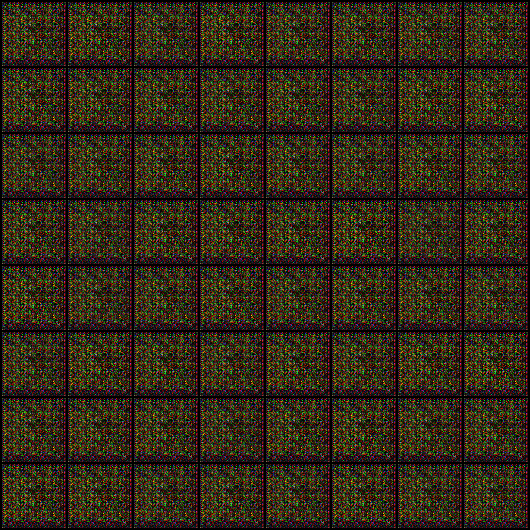

In [42]:
Image(r'C:\Users\SKSR2127\generated\generated-images-0100.png')

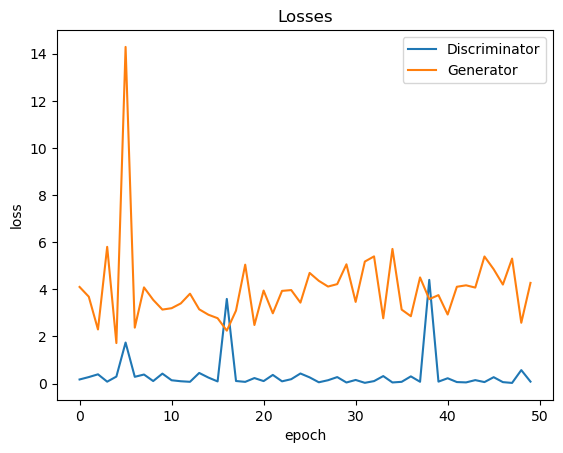

In [41]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');